# De-Identification: Model Training and Evaluation

### Import Libraries

In [1]:
import re, json
import pandas as pd
from pandas import DataFrame
from typing import List, Dict, Any, Tuple

import numpy as np
np.int = np.int32
np.float = np.float64
np.bool = np.bool_
import sklearn

Local Library

In [2]:
from deid_utils import add_basic_features, add_contextual_features, REGEX_postprocessing
from deid_utils import crf_feature_format, robe_dataset, group_words_into_sentences

### Loading the Data

In [3]:
data = pd.read_csv("../home/patient_records.csv")
data.head()

,id,sentence,word,start,end,true_label
0,3,0,Ke,0,2,O
1,3,0,kontrole,3,11,O
2,3,0,",",11,12,O
3,3,0,k,13,14,O
4,3,0,pokračování,15,26,O


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53767 entries, 0 to 53766
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          53767 non-null  int64 
 1   sentence    53767 non-null  int64 
 2   word        53766 non-null  object
 3   start       53767 non-null  int64 
 4   end         53767 non-null  int64 
 5   true_label  53767 non-null  object
dtypes: int64(4), object(2)
memory usage: 2.5+ MB


In [5]:
rows_with_NaN = data.isnull().any(axis=1)[data.isnull().any(axis=1)].index.tolist()
print("Rows with NaN or None values:", rows_with_NaN )

Rows with NaN or None values: [52958]


In [6]:
data.loc[rows_with_NaN[0]]

id            122
sentence        3
word          NaN
start         237
end           239
true_label      O
Name: 52958, dtype: object

In [7]:
data.loc[data.isnull().any(axis=1)[data.isnull().any(axis=1)].index, "word"] = "Nan"

In [8]:
rows_with_NaN = data.isnull().any(axis=1)[data.isnull().any(axis=1)].index.tolist()
print("Rows with NaN or None values:", rows_with_NaN )

Rows with NaN or None values: []


In [9]:
nrows = len(data)
nrows_anno = len(data[data["true_label"] == "A"])
print("Number of words", nrows)
print(f'Number of words for anonymization: {nrows_anno} ({((nrows_anno / nrows) * 100):.2f}%)')

Number of words 53767
Number of words for anonymization: 1853 (3.45%)


### Training, Validation and Testing Datasets

#### Sentence Aggregation

In [10]:
data = group_words_into_sentences(data)
data.head(2)

,id,sentence,word,start,end,true_label
0,3,0,"[Ke, kontrole, ,, k, pokračování, léčby]","[0, 3, 11, 13, 15, 27]","[2, 11, 12, 14, 26, 32]","[O, O, O, O, O, O]"
1,3,1,"[Lab, ., vyšetření, :]","[33, 36, 38, 47]","[36, 37, 47, 48]","[O, O, O, O]"


#### Dataset Split (70:15:15)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
y = data["true_label"]
X = data.drop(["true_label"], axis = 1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 5109
Validation set size: 1095
Test set size: 1095


### Model's Evaluation (Init)

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer

In [15]:
def model_report(y: List[List[str]], y_pred: List[List[str]], labels: List[str]) -> Dict[str, Dict[str, int]]:
    y = list(chain.from_iterable(y))
    y_pred = list(chain.from_iterable(y_pred))
    
    disp = ConfusionMatrixDisplay(confusion_matrix(y, y_pred), display_labels=labels)
    disp.plot(cmap="cividis")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    print(classification_report(y, y_pred, labels=labels, target_names=labels, digits=4))
    return classification_report(y, y_pred, output_dict=True)

In [16]:
def save_model_evaluation(model: str, report: Dict[str, Dict[str, int]], model_report: List[DataFrame]) -> None: 
    model_report[0].loc[model] = [report["O"]['precision'], report["A"]['precision'], report['weighted avg']['precision'], report['macro avg']['precision']]
    model_report[1].loc[model] = [report["O"]['recall'], report["A"]['recall'], report['weighted avg']['recall'], report['macro avg']['recall']]
    model_report[2].loc[model] = [report["O"]['f1-score'], report["A"]['f1-score'], report['weighted avg']['f1-score'], report['macro avg']['f1-score']]
    model_report[3].loc[model] = [report['accuracy']]

In [17]:
def plot_learning_curves(trainer_log: List[Dict[str, int]]) -> None:
    train_loss_values = [trainer_log[i-1].get("loss", None) for i, log in enumerate(trainer_log) if "eval_loss" in log]
    validation_loss_values = [log.get("eval_loss", None) for log in trainer_log if "eval_loss" in log]
    epochs = [trainer_log[i-1].get("epoch", None) for i, log in enumerate(trainer_log) if "eval_loss" in log]

    plt.plot(epochs, train_loss_values, label='Training Loss')
    plt.plot(epochs, validation_loss_values, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('The Learning Curves')
    plt.legend()
    plt.savefig('learning_curves.png')
    plt.show()

Error Analysis

In [18]:
def get_false_predictions(X: DataFrame, y: List[List[str]], y_pred: List[List[str]]) -> Tuple[List[Tuple[str, str, str]], List[Tuple[str, str, str]]]:
    FN = [[(x, true_label, pred_label) for x, true_label, pred_label in zip(x_sentence, true_labels, pred_labels) if true_label != pred_label and pred_label == 'O']
          for x_sentence, true_labels, pred_labels in zip(X, y, y_pred)]
    flat_FN = list(chain.from_iterable(FN))
    FP = [[(x, true_label, pred_label) for x, true_label, pred_label in zip(x_sentence, true_labels, pred_labels) if true_label != pred_label and pred_label == 'A']
          for x_sentence, true_labels, pred_labels in zip(X, y, y_pred)]
    flat_FP = list(chain.from_iterable(FP))
    return flat_FN, flat_FP

## Rule-Based De-Identification: REGEX

#### Imports + Evaluation

In [19]:
from itertools import chain
from collections import Counter

In [20]:
regex_mapping = group_words_into_sentences(pd.read_csv("../home/regex_mapping.csv"))

def evaluate_regex(X: DataFrame, y: DataFrame, regex_mapping: DataFrame) -> None:
    plt.rcParams['axes.grid'] = False
    labels=["A", "O"]
    
    y = list(chain.from_iterable(y))
    merged = pd.merge(X, regex_mapping[["id", "sentence", "regex_rule"]], on=['id', 'sentence'], how='left')['regex_rule']
    y_pred = list(chain.from_iterable(merged))
    
    disp = ConfusionMatrixDisplay(confusion_matrix(y, y_pred), display_labels=labels)
    disp.plot(cmap="cividis")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()
    
    print(classification_report(y, y_pred, labels=labels, target_names=labels, digits=4))

#### REGEX on the whole Dataset

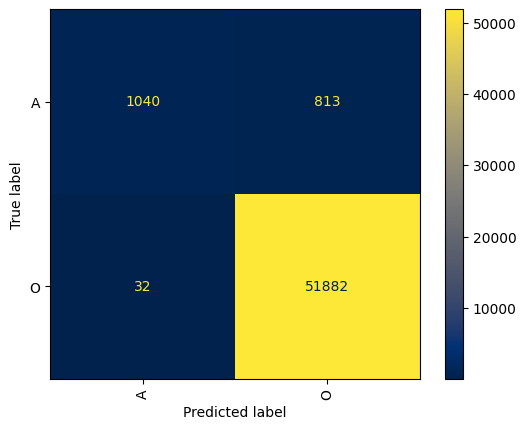

              precision    recall  f1-score   support

           A     0.9701    0.5613    0.7111      1853
           O     0.9846    0.9994    0.9919     51914

    accuracy                         0.9843     53767
   macro avg     0.9774    0.7803    0.8515     53767
weighted avg     0.9841    0.9843    0.9822     53767



In [21]:
evaluate_regex(X, y, regex_mapping)

#### REGEX on Train data

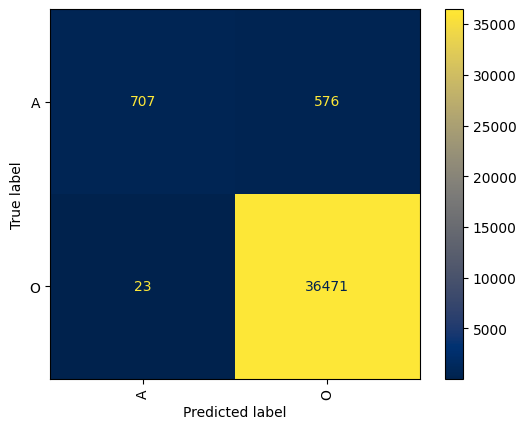

              precision    recall  f1-score   support

           A     0.9685    0.5511    0.7024      1283
           O     0.9845    0.9994    0.9919     36494

    accuracy                         0.9841     37777
   macro avg     0.9765    0.7752    0.8471     37777
weighted avg     0.9839    0.9841    0.9820     37777



In [22]:
evaluate_regex(X_train, y_train, regex_mapping)

#### REGEX on Validation data

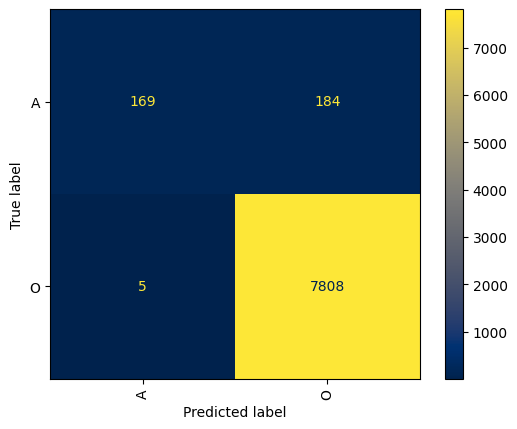

              precision    recall  f1-score   support

           A     0.9713    0.4788    0.6414       353
           O     0.9770    0.9994    0.9880      7813

    accuracy                         0.9769      8166
   macro avg     0.9741    0.7391    0.8147      8166
weighted avg     0.9767    0.9769    0.9731      8166



In [23]:
evaluate_regex(X_val, y_val, regex_mapping)

#### REGEX on Test data

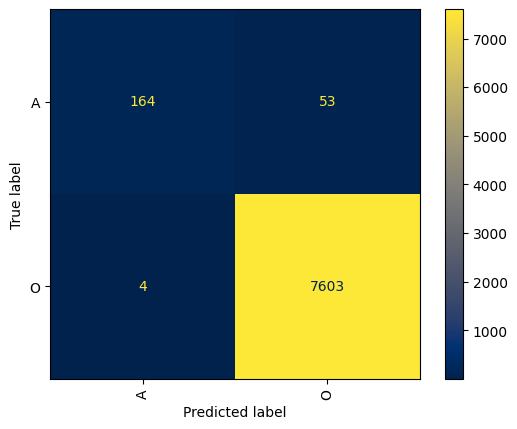

              precision    recall  f1-score   support

           A     0.9762    0.7558    0.8519       217
           O     0.9931    0.9995    0.9963      7607

    accuracy                         0.9927      7824
   macro avg     0.9846    0.8776    0.9241      7824
weighted avg     0.9926    0.9927    0.9923      7824



In [24]:
evaluate_regex(X_test, y_test, regex_mapping)

#### Error Analysis

In [25]:
y_pred_regex = list(pd.merge(X, regex_mapping[["id", "sentence", "regex_rule"]], on=['id', 'sentence'], how='left')['regex_rule'])

In [26]:
FN_regex, FP_regex = get_false_predictions(list(X['word']), list(y), y_pred_regex)

In [27]:
print("Whole Dataset")
print("False Negatives:")
for false_negative in FN_regex:
    pass
    #print(false_negative)

print("\nFalse Positives:")
for false_positive in FP_regex:
    pass
    #print(false_positive)

Whole Dataset
False Negatives:

False Positives:


## ML-Based De-Identification

### CRF Classifier

##### Imports

In [28]:
from sklearn.metrics import make_scorer, recall_score
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV

import scipy.stats

import eli5
from IPython.core.display import HTML

2024-03-31 13:32:21.087251: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-31 13:32:23.030815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Evaluation Initialization

In [29]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))   

Validation data evaluation report

In [30]:
precision_crf = pd.DataFrame(columns=["O", "A", "Weighted Avg", "Macro Avg"])
recall_crf = pd.DataFrame(columns=["O", "A", "Weighted Avg", "Macro Avg"])
f1_score_crf = pd.DataFrame(columns=["O", "A", "Weighted Avg", "Macro Avg"])
accuracy_crf = pd.DataFrame(columns=["Accuracy"])

crf_models_report = [precision_crf, recall_crf, f1_score_crf, accuracy_crf]

Test data evaluation report

In [31]:
precision_test_crf = pd.DataFrame(columns=["O", "A", "Weighted Avg", "Macro Avg"])
recall_test_crf = pd.DataFrame(columns=["O", "A", "Weighted Avg", "Macro Avg"])
f1_score_test_crf = pd.DataFrame(columns=["O", "A", "Weighted Avg", "Macro Avg"])
accuracy_test_crf = pd.DataFrame(columns=["Accuracy"])

crf_test_models_report = [precision_test_crf, recall_test_crf, f1_score_test_crf, accuracy_test_crf]

#### CRF Models without REGEX 

##### CRF Model No.1 Basic Feature Set

In [32]:
REGEX_FEATURE = False

Feature Addition

In [33]:
X_train_crf_df = add_basic_features(X_train, REGEX_FEATURE).drop(["id", "sentence", "start", "end"], axis=1)
X_val_crf_df = add_basic_features(X_val, REGEX_FEATURE).drop(["id", "sentence", "start", "end"], axis=1)
X_test_crf_df = add_basic_features(X_test, REGEX_FEATURE).drop(["id", "sentence", "start", "end"], axis=1)

In [34]:
X_train_crf_df.head(2)

,word,word.position,word[-3:],word.POS_tag,word.len(),word.istitle(),word.isdigit(),bias
0,"[Lékař, :]","[0.6, 0.6]","[kař, :]","[NN, Z:]","[5, 1]","[True, False]","[False, False]",1.0
1,"[P_Laktátdehydrogenáza, :]","[0.12, 0.13]","[áza, :]","[Q3, Z:]","[21, 1]","[True, False]","[False, False]",1.0


Transformation into the Acceptable Feature Format for CRF

In [35]:
X_train_crf = crf_feature_format(X_train_crf_df)
y_train_crf = y_train.tolist()
X_val_crf = crf_feature_format(X_val_crf_df)
y_val_crf = y_val.tolist()
X_test_crf = crf_feature_format(X_test_crf_df)
y_test_crf = y_test.tolist()

**Feature Set:**

In [36]:
[x for x in X_train_crf[0][0].keys()]

['word',
 'word.position',
 'word[-3:]',
 'word.POS_tag',
 'word.len()',
 'word.istitle()',
 'word.isdigit()',
 'bias']

###### Model with 'Default' Parameters

In [37]:
crf1 = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
crf1.fit(X_train_crf, y_train_crf)

y_val_pred = crf1.predict(X_val_crf)

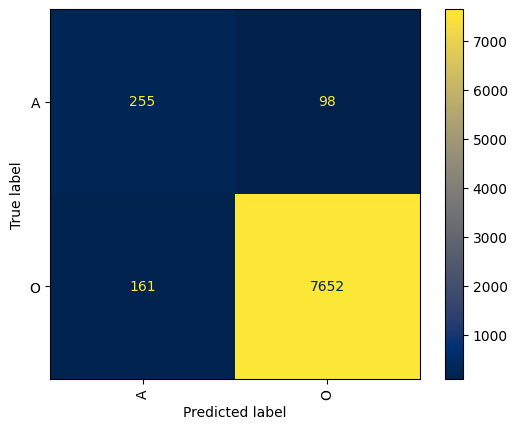

              precision    recall  f1-score   support

           A     0.6130    0.7224    0.6632       353
           O     0.9874    0.9794    0.9834      7813

    accuracy                         0.9683      8166
   macro avg     0.8002    0.8509    0.8233      8166
weighted avg     0.9712    0.9683    0.9695      8166



In [38]:
labels = sorted(list(crf1.classes_))

_ = model_report(y_val_crf, y_val_pred, labels)

###### Manual Tuning of the Parameters

In [39]:
crf1_tuned = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=0.01,
    max_iterations=200,
    all_possible_transitions=True
)
crf1_tuned.fit(X_train_crf, y_train_crf)

y_val_pred = crf1_tuned.predict(X_val_crf)

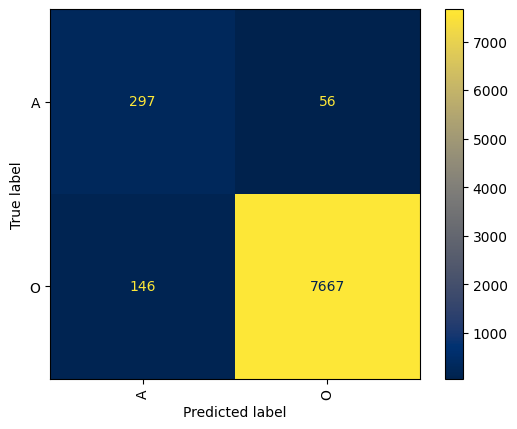

              precision    recall  f1-score   support

           A     0.6704    0.8414    0.7462       353
           O     0.9927    0.9813    0.9870      7813

    accuracy                         0.9753      8166
   macro avg     0.8316    0.9113    0.8666      8166
weighted avg     0.9788    0.9753    0.9766      8166



In [40]:
_ = model_report(y_val_crf, y_val_pred, labels)

###### Hyperparameter Optimization

In [41]:
crf_ = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    all_possible_transitions = True,
)
scorer = make_scorer(metrics.flat_recall_score,
                     average='binary', 
                     pos_label='A',
                     zero_division='warn') 

In [42]:
params_space1 = {
    'c1': scipy.stats.expon(scale=0.3),
    'c2': scipy.stats.expon(scale=0.005),
    'max_iterations': [n for n in range(50, 201, 25)]
}

In [43]:
rs1 = RandomizedSearchCV(crf_, 
                        params_space1,
                        cv=5,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=200,
                        scoring=scorer,
                        return_train_score=True,
                        random_state=100)
rs1.fit(X_train_crf, y_train_crf)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.2min finished


RandomizedSearchCV(cv=5,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f22c6cb2670>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f22c6c5e3d0>,
                                        'max_iterations': [50, 75, 100, 125,
                                                           150, 175, 200]},
                   random_state=100, return_train_score=True,
                   scoring=make_scorer(flat_recall_score, average=binary, pos_label=A, zero_division=warn),
                   verbose=1)

In [44]:
print('best params:', rs1.best_params_)
print('best CV score:', rs1.best_score_)
print('model size: {:0.2f}M'.format(rs1.best_estimator_.size_ / 1000000))

best params: {'c1': 0.8403240363558669, 'c2': 0.002129008485530578, 'max_iterations': 75}
best CV score: 0.709695139315181
model size: 0.04M


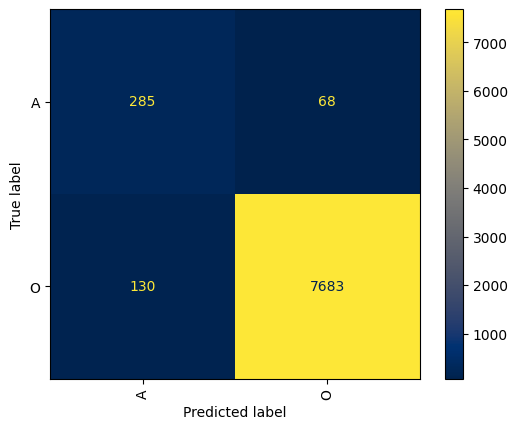

              precision    recall  f1-score   support

           A     0.6867    0.8074    0.7422       353
           O     0.9912    0.9834    0.9873      7813

    accuracy                         0.9758      8166
   macro avg     0.8390    0.8954    0.8647      8166
weighted avg     0.9781    0.9758    0.9767      8166



In [45]:
crf1_optimized = rs1.best_estimator_
y_val_pred = crf1_optimized.predict(X_val_crf)
crf1_optimized_report = model_report(y_val_crf, y_val_pred, labels)

In [46]:
print("Top positive:")
#print_state_features(Counter(crf1_optimized.state_features_).most_common(30))

print("\nTop negative:")
#print_state_features(Counter(crf1_optimized.state_features_).most_common()[-30:])

Top positive:

Top negative:


In [47]:
save_model_evaluation("CRF Basic Features", crf1_optimized_report, crf_models_report)

##### CRF Model No.2 Contextual Feature Set

In [48]:
X_train_crf2_df = add_contextual_features(X_train_crf_df, REGEX_FEATURE, 1)
X_val_crf2_df = add_contextual_features(X_val_crf_df, REGEX_FEATURE, 1)
X_test_crf2_df = add_contextual_features(X_test_crf_df, REGEX_FEATURE, 1)

X_train_crf2_df = add_contextual_features(X_train_crf2_df, REGEX_FEATURE, 2)
X_val_crf2_df = add_contextual_features(X_val_crf2_df, REGEX_FEATURE, 2)
X_test_crf2_df = add_contextual_features(X_test_crf2_df, REGEX_FEATURE, 2)

In [49]:
X_train_crf2_df.head(2)

,word,word.position,word[-3:],word.POS_tag,word.len(),word.istitle(),word.isdigit(),bias,-1:word,-1:word[-3:],...,-2:word.len(),-2:word.istitle(),-2:word.isdigit(),-2:word.POS_tag,+2:word,+2:word[-3:],+2:word.len(),+2:word.istitle(),+2:word.isdigit(),+2:word.POS_tag
0,"[Lékař, :]","[0.6, 0.6]","[kař, :]","[NN, Z:]","[5, 1]","[True, False]","[False, False]",1.0,"[BOS, Lékař]","[BOS, kař]",...,"[0, 0]","[False, False]","[False, False]","[Z:, Z:]","[EOS, EOS]","[EOS, EOS]","[0, 0]","[False, False]","[False, False]","[Z:, Z:]"
1,"[P_Laktátdehydrogenáza, :]","[0.12, 0.13]","[áza, :]","[Q3, Z:]","[21, 1]","[True, False]","[False, False]",1.0,"[BOS, P_Laktátdehydrogenáza]","[BOS, áza]",...,"[0, 0]","[False, False]","[False, False]","[Z:, Z:]","[EOS, EOS]","[EOS, EOS]","[0, 0]","[False, False]","[False, False]","[Z:, Z:]"


In [50]:
X_train_crf2 = crf_feature_format(X_train_crf2_df)
X_val_crf2 = crf_feature_format(X_val_crf2_df)
X_test_crf2 = crf_feature_format(X_test_crf2_df)

**Feature Set:**

In [51]:
[x for x in X_train_crf2[0][0].keys()]

['word',
 'word.position',
 'word[-3:]',
 'word.POS_tag',
 'word.len()',
 'word.istitle()',
 'word.isdigit()',
 'bias',
 '-1:word',
 '-1:word[-3:]',
 '-1:word.len()',
 '-1:word.istitle()',
 '-1:word.isdigit()',
 '-1:word.POS_tag',
 '+1:word',
 '+1:word[-3:]',
 '+1:word.len()',
 '+1:word.istitle()',
 '+1:word.isdigit()',
 '+1:word.POS_tag',
 '-2:word',
 '-2:word[-3:]',
 '-2:word.len()',
 '-2:word.istitle()',
 '-2:word.isdigit()',
 '-2:word.POS_tag',
 '+2:word',
 '+2:word[-3:]',
 '+2:word.len()',
 '+2:word.istitle()',
 '+2:word.isdigit()',
 '+2:word.POS_tag']

###### Model with Default Parameters

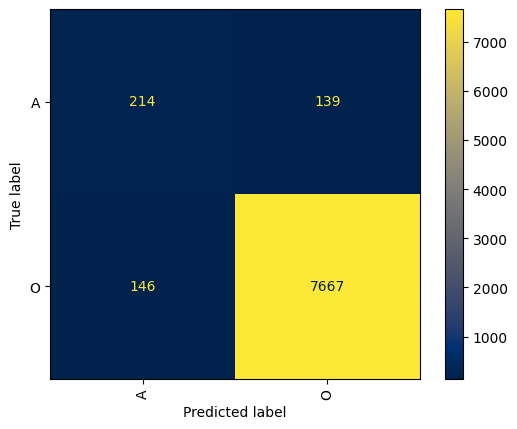

              precision    recall  f1-score   support

           A     0.5944    0.6062    0.6003       353
           O     0.9822    0.9813    0.9818      7813

    accuracy                         0.9651      8166
   macro avg     0.7883    0.7938    0.7910      8166
weighted avg     0.9654    0.9651    0.9653      8166



In [52]:
crf2 = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
crf2.fit(X_train_crf2, y_train_crf)

y_val_pred = crf2.predict(X_val_crf2)

_ = model_report(y_val_crf, y_val_pred, labels)

###### Manual Tuning of the Parameters

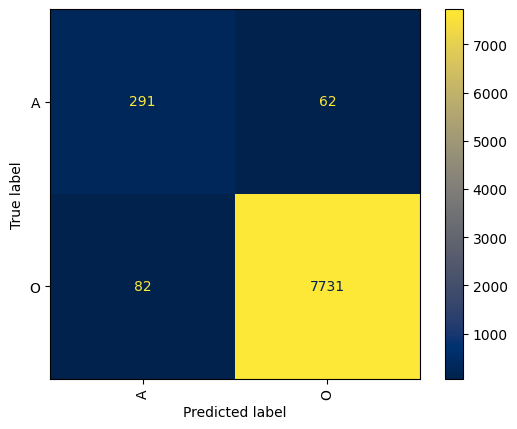

              precision    recall  f1-score   support

           A     0.7802    0.8244    0.8017       353
           O     0.9920    0.9895    0.9908      7813

    accuracy                         0.9824      8166
   macro avg     0.8861    0.9069    0.8962      8166
weighted avg     0.9829    0.9824    0.9826      8166



In [53]:
crf2_tuned = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=1.0,
    c2=0.01,
    max_iterations=200,
    all_possible_transitions=True
)
crf2_tuned.fit(X_train_crf2, y_train_crf)

y_val_pred = crf2_tuned.predict(X_val_crf2)

_ = model_report(y_val_crf, y_val_pred, labels)

###### Hyperparameter Optimization

In [54]:
params_space2 = {
    'c1': scipy.stats.expon(scale=1.1), 
    'c2': scipy.stats.expon(scale=0.02),
    'max_iterations': [n for n in range(50, 201, 25)]
}

In [55]:
rs2 = RandomizedSearchCV(crf_, 
                        params_space2,
                        cv=5,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=200,
                        scoring=scorer,
                        return_train_score=True,
                        random_state=100)
rs2.fit(X_train_crf2, y_train_crf)

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  7.1min finished


RandomizedSearchCV(cv=5,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f2325fbc190>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f2325ef3610>,
                                        'max_iterations': [50, 75, 100, 125,
                                                           150, 175, 200]},
                   random_state=100, return_train_score=True,
                   scoring=make_scorer(flat_recall_score, average=binary, pos_label=A, zero_division=warn),
                   verbose=1)

In [56]:
print('best params:', rs2.best_params_)
print('best CV score:', rs2.best_score_)
print('model size: {:0.2f}M'.format(rs2.best_estimator_.size_ / 1000000))

best params: {'c1': 0.6584541767972372, 'c2': 0.005661727498552445, 'max_iterations': 175}
best CV score: 0.6822664256268215
model size: 0.09M


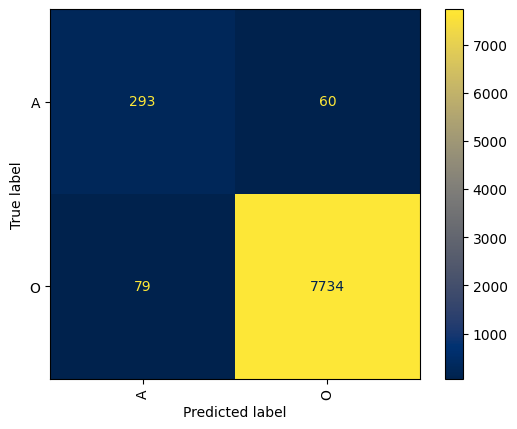

              precision    recall  f1-score   support

           A     0.7876    0.8300    0.8083       353
           O     0.9923    0.9899    0.9911      7813

    accuracy                         0.9830      8166
   macro avg     0.8900    0.9100    0.8997      8166
weighted avg     0.9835    0.9830    0.9832      8166



In [57]:
crf2_optimized = rs2.best_estimator_
y_val_pred = crf2_optimized.predict(X_val_crf2)
crf2_optimized_report = model_report(y_val_crf, y_val_pred, labels)

In [58]:
print("Top positive:")
print_state_features(Counter(crf2_optimized.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf2_optimized.state_features_).most_common()[-30:])

Top positive:
6.700811 O        word.POS_tag:RR
6.436698 A        word[-3:]:jov
4.747076 A        word:MUDr.
4.747076 A        word[-3:]:Dr.
4.215729 A        word:doc.
4.215729 A        word[-3:]:oc.
4.198610 A        word[-3:]:.2.
4.183882 O        word:10/2020
3.871836 A        word[-3:]:/11
3.696129 A        word[-3:]:10.
3.589457 A        word:hodině
3.534504 A        word:Hodonín
3.534504 A        word[-3:]:nín
3.454550 A        word:dr.
3.454550 A        word[-3:]:dr.
3.243677 A        word[-3:]:.19
3.073774 A        word[-3:]:018
2.958595 O        word:1/2020
2.947690 A        word[-3:]:.6.
2.903756 A        word[-3:]::00
2.867522 A        word[-3:]:.21
2.834603 A        word[-3:]:.7.
2.718280 A        word[-3:]:.20
2.676453 A        word[-3:]:020
2.614481 A        -1:word:>
2.614481 A        -1:word[-3:]:>
2.600943 A        word:šička
2.552903 A        -1:word:Ph.D
2.552903 A        -1:word[-3:]:h.D
2.500802 A        word[-3:]:.18

Top negative:
-1.319278 O        word[-3:]:OC

In [59]:
save_model_evaluation("CRF Contextual Features", crf2_optimized_report, crf_models_report)

###### Evaluation on Test Data

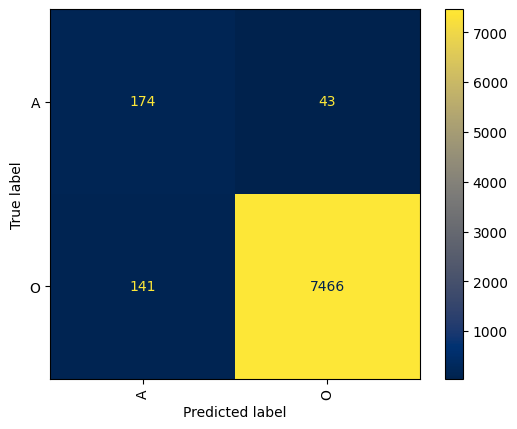

              precision    recall  f1-score   support

           A     0.5524    0.8018    0.6541       217
           O     0.9943    0.9815    0.9878      7607

    accuracy                         0.9765      7824
   macro avg     0.7733    0.8917    0.8210      7824
weighted avg     0.9820    0.9765    0.9786      7824



In [60]:
y_test_pred = crf2_optimized.predict(X_test_crf2)
crf2_optimized_report_test = model_report(y_test_crf, y_test_pred, labels)

In [61]:
save_model_evaluation("CRF Contextual Features", crf2_optimized_report_test, crf_test_models_report)

#### CRF Models with REGEX

##### CRF Model No.3 Basic + REGEX Feature Set

In [62]:
REGEX_FEATURE = True

In [63]:
X_train_crf3_df = add_basic_features(X_train, REGEX_FEATURE).drop(["id", "sentence", "start", "end"], axis=1)
X_val_crf3_df = add_basic_features(X_val, REGEX_FEATURE).drop(["id", "sentence", "start", "end"], axis=1)
X_test_crf3_df = add_basic_features(X_test, REGEX_FEATURE).drop(["id", "sentence", "start", "end"], axis=1)

In [64]:
X_train_crf3 = crf_feature_format(X_train_crf3_df)
X_val_crf3 = crf_feature_format(X_val_crf3_df)
X_test_crf3 = crf_feature_format(X_test_crf3_df)

In [65]:
X_train_crf3_df.head(2)

,word,regex_rule,word.position,word[-3:],word.POS_tag,word.len(),word.istitle(),word.isdigit(),bias
0,"[Lékař, :]","[O, O]","[0.6, 0.6]","[kař, :]","[NN, Z:]","[5, 1]","[True, False]","[False, False]",1.0
1,"[P_Laktátdehydrogenáza, :]","[O, O]","[0.12, 0.13]","[áza, :]","[Q3, Z:]","[21, 1]","[True, False]","[False, False]",1.0


**Feature Set:**

In [140]:
[x for x in X_train_crf3[0][0].keys()]

['word',
 'regex_rule',
 'word.position',
 'word[-3:]',
 'word.POS_tag',
 'word.len()',
 'word.istitle()',
 'word.isdigit()',
 'bias']

###### Model with Default Parameters

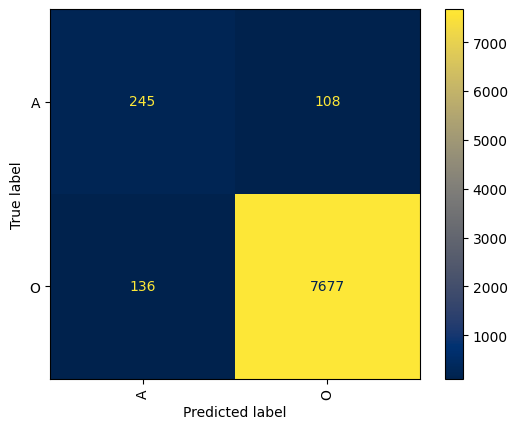

              precision    recall  f1-score   support

           A     0.6430    0.6941    0.6676       353
           O     0.9861    0.9826    0.9844      7813

    accuracy                         0.9701      8166
   macro avg     0.8146    0.8383    0.8260      8166
weighted avg     0.9713    0.9701    0.9707      8166



In [67]:
crf3 = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
crf3.fit(X_train_crf3, y_train_crf)

y_val_pred = crf3.predict(X_val_crf3)
_ = model_report(y_val_crf, y_val_pred, labels)

###### Manual Tuning of the Parameters

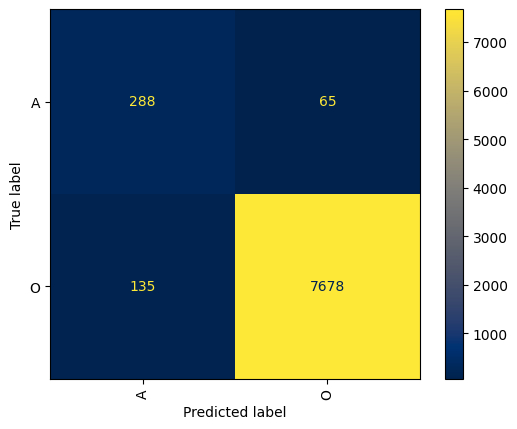

              precision    recall  f1-score   support

           A     0.6809    0.8159    0.7423       353
           O     0.9916    0.9827    0.9871      7813

    accuracy                         0.9755      8166
   macro avg     0.8362    0.8993    0.8647      8166
weighted avg     0.9782    0.9755    0.9766      8166



In [68]:
crf3_tuned = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=1.5,
    c2=0.03,
    max_iterations=200,
    all_possible_transitions=True
)
crf3_tuned.fit(X_train_crf3, y_train_crf)

y_val_pred = crf3_tuned.predict(X_val_crf3)
_ = model_report(y_val_crf, y_val_pred, labels)

###### Hyperparameter Optimization

In [69]:
params_space3 = {
    'c1': scipy.stats.expon(scale=1.8),
    'c2': scipy.stats.expon(scale=0.1),
    'max_iterations': [n for n in range(50, 201, 25)]
}

In [70]:
rs3 = RandomizedSearchCV(crf_, 
                        params_space3,
                        cv=5,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=200,
                        scoring=scorer,
                        return_train_score=True,
                        random_state=42)
rs3.fit(X_train_crf3, y_train_crf)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.5min finished


RandomizedSearchCV(cv=5,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f23216ba8e0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f232165a4c0>,
                                        'max_iterations': [50, 75, 100, 125,
                                                           150, 175, 200]},
                   random_state=42, return_train_score=True,
                   scoring=make_scorer(flat_recall_score, average=binary, pos_label=A, zero_division=warn),
                   verbose=1)

In [71]:
print('best params:', rs3.best_params_)
print('best CV score:', rs3.best_score_)
print('model size: {:0.2f}M'.format(rs3.best_estimator_.size_ / 1000000))

best params: {'c1': 0.9190690862392462, 'c2': 0.004778961126377176, 'max_iterations': 125}
best CV score: 0.7431843245769075
model size: 0.02M


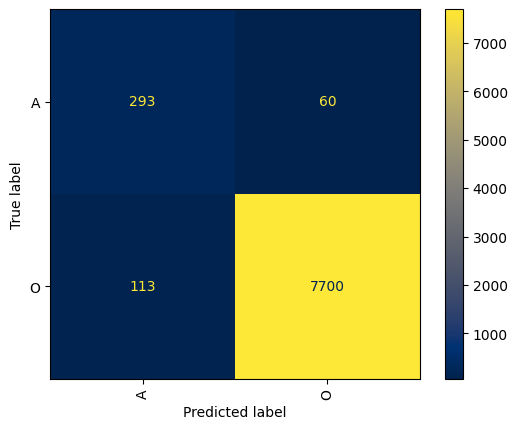

              precision    recall  f1-score   support

           A     0.7217    0.8300    0.7721       353
           O     0.9923    0.9855    0.9889      7813

    accuracy                         0.9788      8166
   macro avg     0.8570    0.9078    0.8805      8166
weighted avg     0.9806    0.9788    0.9795      8166



In [72]:
crf3_optimized = rs3.best_estimator_
y_val_pred = crf3_optimized.predict(X_val_crf3)
crf3_optimized_report = model_report(y_val_crf, y_val_pred, labels)

In [74]:
print("Top positive:")
#print_state_features(Counter(crf3_optimized.state_features_).most_common(30))

print("\nTop negative:")
#print_state_features(Counter(crf3_optimized.state_features_).most_common()[-30:])

Top positive:

Top negative:


In [75]:
save_model_evaluation("CRF Basic Features + REGEX", crf3_optimized_report, crf_models_report)

##### CRF Model No.4 Contextual + REGEX Feature Set

In [76]:
X_train_crf4_df = add_contextual_features(X_train_crf3_df, REGEX_FEATURE, 1)
X_val_crf4_df = add_contextual_features(X_val_crf3_df, REGEX_FEATURE, 1)
X_test_crf4_df = add_contextual_features(X_test_crf3_df, REGEX_FEATURE, 1)

X_train_crf4_df = add_contextual_features(X_train_crf4_df, REGEX_FEATURE, 2)
X_val_crf4_df = add_contextual_features(X_val_crf4_df, REGEX_FEATURE, 2)
X_test_crf4_df = add_contextual_features(X_test_crf4_df, REGEX_FEATURE, 2)

In [77]:
X_train_crf4 = crf_feature_format(X_train_crf4_df)
X_val_crf4 = crf_feature_format(X_val_crf4_df)
X_test_crf4 = crf_feature_format(X_test_crf4_df)

In [78]:
X_train_crf4_df.head(3)

,word,regex_rule,word.position,word[-3:],word.POS_tag,word.len(),word.istitle(),word.isdigit(),bias,+1:word.regex_rule,...,-2:word.len(),-2:word.istitle(),-2:word.isdigit(),-2:word.POS_tag,+2:word,+2:word[-3:],+2:word.len(),+2:word.istitle(),+2:word.isdigit(),+2:word.POS_tag
0,"[Lékař, :]","[O, O]","[0.6, 0.6]","[kař, :]","[NN, Z:]","[5, 1]","[True, False]","[False, False]",1.0,"[O, O]",...,"[0, 0]","[False, False]","[False, False]","[Z:, Z:]","[EOS, EOS]","[EOS, EOS]","[0, 0]","[False, False]","[False, False]","[Z:, Z:]"
1,"[P_Laktátdehydrogenáza, :]","[O, O]","[0.12, 0.13]","[áza, :]","[Q3, Z:]","[21, 1]","[True, False]","[False, False]",1.0,"[O, O]",...,"[0, 0]","[False, False]","[False, False]","[Z:, Z:]","[EOS, EOS]","[EOS, EOS]","[0, 0]","[False, False]","[False, False]","[Z:, Z:]"
2,"[16, :, mamila, :]","[O, O, O, O]","[0.68, 0.68, 0.68, 0.69]","[16, :, ila, :]","[C=, Z:, X@, Z:]","[2, 1, 6, 1]","[False, False, False, False]","[True, False, False, False]",1.0,"[O, O, O, O]",...,"[0, 0, 2, 1]","[False, False, False, False]","[False, False, True, False]","[Z:, Z:, C=, Z:]","[mamila, :, EOS, EOS]","[ila, :, EOS, EOS]","[6, 1, 0, 0]","[False, False, False, False]","[False, False, False, False]","[X@, Z:, Z:, Z:]"


**Feature Set:**

In [79]:
[x for x in X_train_crf4[0][0].keys()]

['word',
 'regex_rule',
 'word.position',
 'word[-3:]',
 'word.POS_tag',
 'word.len()',
 'word.istitle()',
 'word.isdigit()',
 'bias',
 '+1:word.regex_rule',
 '-1:word.regex_rule',
 '-1:word',
 '-1:word[-3:]',
 '-1:word.len()',
 '-1:word.istitle()',
 '-1:word.isdigit()',
 '-1:word.POS_tag',
 '+1:word',
 '+1:word[-3:]',
 '+1:word.len()',
 '+1:word.istitle()',
 '+1:word.isdigit()',
 '+1:word.POS_tag',
 '+2:word.regex_rule',
 '-2:word.regex_rule',
 '-2:word',
 '-2:word[-3:]',
 '-2:word.len()',
 '-2:word.istitle()',
 '-2:word.isdigit()',
 '-2:word.POS_tag',
 '+2:word',
 '+2:word[-3:]',
 '+2:word.len()',
 '+2:word.istitle()',
 '+2:word.isdigit()',
 '+2:word.POS_tag']

###### Model with Default Parameters

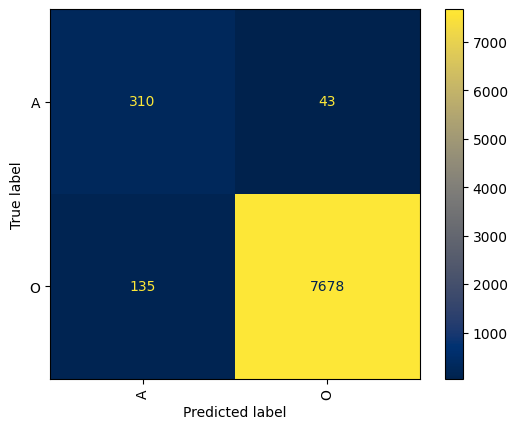

              precision    recall  f1-score   support

           A     0.6966    0.8782    0.7769       353
           O     0.9944    0.9827    0.9885      7813

    accuracy                         0.9782      8166
   macro avg     0.8455    0.9305    0.8827      8166
weighted avg     0.9816    0.9782    0.9794      8166



In [80]:
crf4 = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
crf4.fit(X_train_crf4, y_train_crf)

y_val_pred = crf4.predict(X_val_crf4)
_ = model_report(y_val_crf, y_val_pred, labels)

###### Manual Tuning of the Parameters

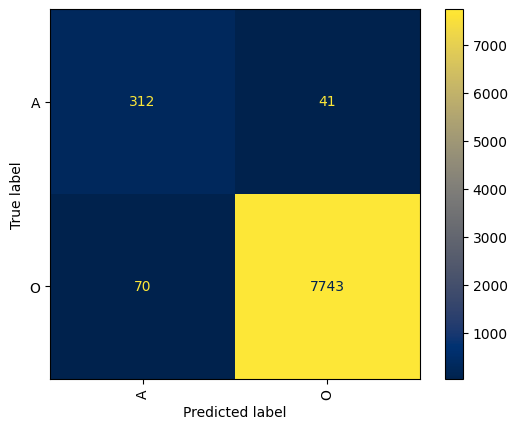

              precision    recall  f1-score   support

           A     0.8168    0.8839    0.8490       353
           O     0.9947    0.9910    0.9929      7813

    accuracy                         0.9864      8166
   macro avg     0.9057    0.9374    0.9209      8166
weighted avg     0.9870    0.9864    0.9867      8166



In [81]:
crf4_tuned = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=1.0,
    c2=0.03,
    max_iterations=200,
    all_possible_transitions=True
)
crf4_tuned.fit(X_train_crf4, y_train_crf)

y_val_pred = crf4_tuned.predict(X_val_crf4)
_ = model_report(y_val_crf, y_val_pred, labels)

###### Hyperparameter Optimization

In [82]:
params_space4 = {
    'c1': scipy.stats.expon(scale=1.0),
    'c2': scipy.stats.expon(scale=0.01),
    'max_iterations': [n for n in range(50, 201, 25)]
}

In [83]:
rs4 = RandomizedSearchCV(crf_, 
                        params_space4,
                        cv=5,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=200,
                        scoring=scorer,
                        return_train_score=True,
                        random_state=100)
rs4.fit(X_train_crf4, y_train_crf)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  8.0min finished


RandomizedSearchCV(cv=5,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f22c5332ac0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f22c52703d0>,
                                        'max_iterations': [50, 75, 100, 125,
                                                           150, 175, 200]},
                   random_state=100, return_train_score=True,
                   scoring=make_scorer(flat_recall_score, average=binary, pos_label=A, zero_division=warn),
                   verbose=1)

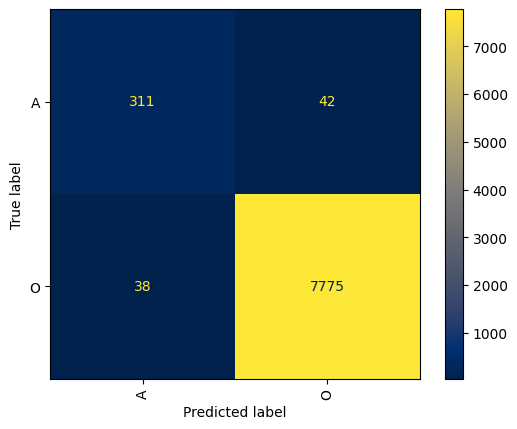

              precision    recall  f1-score   support

           A     0.8911    0.8810    0.8860       353
           O     0.9946    0.9951    0.9949      7813

    accuracy                         0.9902      8166
   macro avg     0.9429    0.9381    0.9405      8166
weighted avg     0.9902    0.9902    0.9902      8166



In [84]:
crf4_optimized = rs4.best_estimator_
y_val_pred = crf4_optimized.predict(X_val_crf4)
crf4_optimized_report = model_report(y_val_crf, y_val_pred, labels)

In [86]:
print('best params:', rs4.best_params_)
print('best CV score:', rs4.best_score_)
print('model size: {:0.2f}M'.format(rs4.best_estimator_.size_ / 1000000))

best params: {'c1': 1.0047805146831295, 'c2': 0.03169968273894568, 'max_iterations': 50}
best CV score: 0.7658556328045271
model size: 0.05M


In [87]:
print("Top positive:")
print_state_features(Counter(crf4_optimized.state_features_).most_common(20))

print("\nTop negative:")
print_state_features(Counter(crf4_optimized.state_features_).most_common()[-20:])

Top positive:
3.307686 A        regex_rule:A
3.156626 O        word.POS_tag:RR
2.258135 A        word:Hodonín
2.258135 A        word[-3:]:nín
1.932901 A        word:MOÚ
1.932901 A        word[-3:]:MOÚ
1.871972 A        word[-3:]:/11
1.768286 O        -1:word.regex_rule:A
1.753479 A        -1:word:>
1.753479 A        -1:word[-3:]:>
1.658722 O        +1:word.regex_rule:A
1.625908 A        +1:word[-3:]:ová
1.595914 O        +1:word[-3:]:021
1.563862 A        word[-3:]:ová
1.467851 A        word[-3:]:020
1.445178 A        -1:word:dnech
1.302309 A        word:Blansko
1.266571 O        word[-3:]:ení
1.236587 O        +2:word[-3:]:ová
1.219988 A        word[-3:]:jov

Top negative:
-0.940008 O        word[-3:]:018
-0.961885 O        word:OMKOCH
-0.961885 O        word[-3:]:OCH
-1.013015 O        -1:word[-3:]:tel
-1.019121 O        word[-3:]:tel
-1.100679 O        word[-3:]:od.
-1.129747 O        word.POS_tag:C=
-1.130019 O        word[-3:]:021
-1.204221 O        -2:word:PA
-1.204221 O        -

In [88]:
import eli5

eli5.show_weights(crf4_optimized, top=(20, 20))

In [89]:
save_model_evaluation("CRF Contextual Features + REGEX", crf4_optimized_report, crf_models_report)

###### Evaluation on Test Data

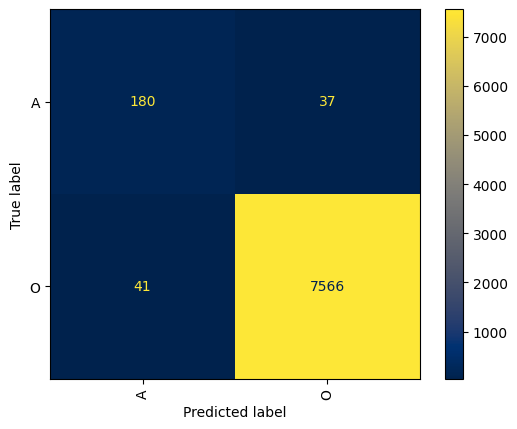

              precision    recall  f1-score   support

           A     0.8145    0.8295    0.8219       217
           O     0.9951    0.9946    0.9949      7607

    accuracy                         0.9900      7824
   macro avg     0.9048    0.9121    0.9084      7824
weighted avg     0.9901    0.9900    0.9901      7824



In [90]:
crf4_optimized = rs4.best_estimator_
y_test_pred = crf4_optimized.predict(X_test_crf4)
crf4_optimized_report_test = model_report(y_test_crf, y_test_pred, labels)

In [91]:
save_model_evaluation("CRF Contextual Features + REGEX", crf4_optimized_report_test, crf_test_models_report)

##### CRF Model No.5 Basic Feature Set + REGEX PostProcessing

Validation Set

In [92]:
y_val_pred = crf1_optimized.predict(X_val_crf)
y_val_pred = REGEX_postprocessing(X_val, y_val_pred)

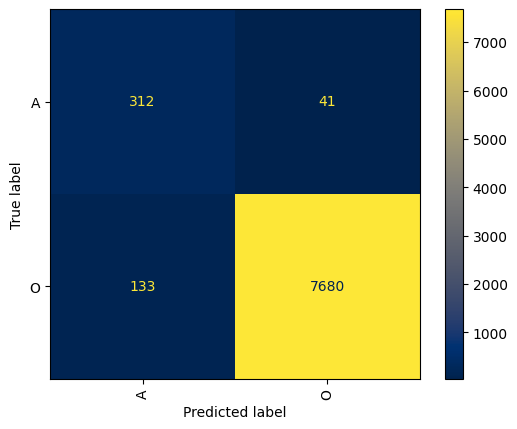

              precision    recall  f1-score   support

           A     0.7011    0.8839    0.7820       353
           O     0.9947    0.9830    0.9888      7813

    accuracy                         0.9787      8166
   macro avg     0.8479    0.9334    0.8854      8166
weighted avg     0.9820    0.9787    0.9799      8166



In [93]:
crf1_optimized_postregex_report = model_report(y_val_crf, y_val_pred, labels)

In [94]:
save_model_evaluation("CRF Basic Features + REGEX PostProcessing", crf1_optimized_postregex_report , crf_models_report)

Test Set

In [95]:
y_test_pred = crf1_optimized.predict(X_test_crf)
y_test_pred = REGEX_postprocessing(X_test, y_test_pred)

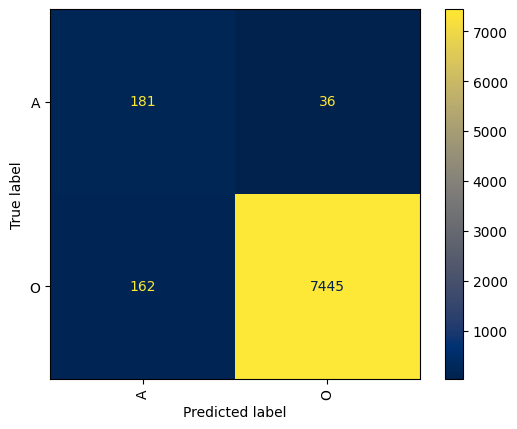

              precision    recall  f1-score   support

           A     0.5277    0.8341    0.6464       217
           O     0.9952    0.9787    0.9869      7607

    accuracy                         0.9747      7824
   macro avg     0.7614    0.9064    0.8167      7824
weighted avg     0.9822    0.9747    0.9774      7824



In [96]:
crf1_optimized_postregex_report_test = model_report(y_test_crf, y_test_pred, labels)

In [98]:
save_model_evaluation("CRF Basic Features + REGEX PostProcessing", crf1_optimized_postregex_report_test , crf_test_models_report)

##### CRF Model No.6 Contextual Feature Set + REGEX PostProcessing

Validation Set

In [99]:
y_val_pred = crf2_optimized.predict(X_val_crf2)
y_val_pred = REGEX_postprocessing(X_val, y_val_pred)

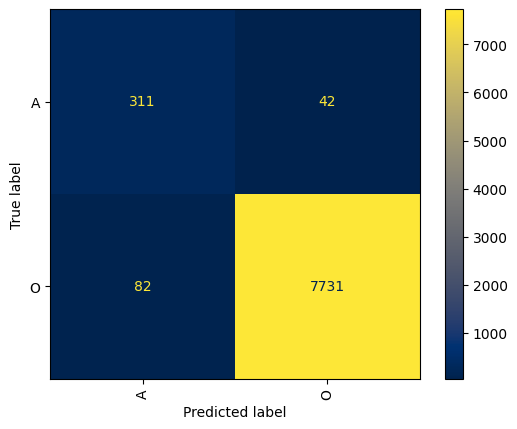

              precision    recall  f1-score   support

           A     0.7913    0.8810    0.8338       353
           O     0.9946    0.9895    0.9920      7813

    accuracy                         0.9848      8166
   macro avg     0.8930    0.9353    0.9129      8166
weighted avg     0.9858    0.9848    0.9852      8166



In [100]:
crf2_optimized_postregex_report = model_report(y_val_crf, y_val_pred, labels)

In [101]:
save_model_evaluation("CRF Contextual Features + REGEX PostProcessing", crf2_optimized_postregex_report, crf_models_report)

Test Set

In [102]:
y_test_pred = crf2_optimized.predict(X_test_crf2)
y_test_pred = REGEX_postprocessing(X_test, y_test_pred)

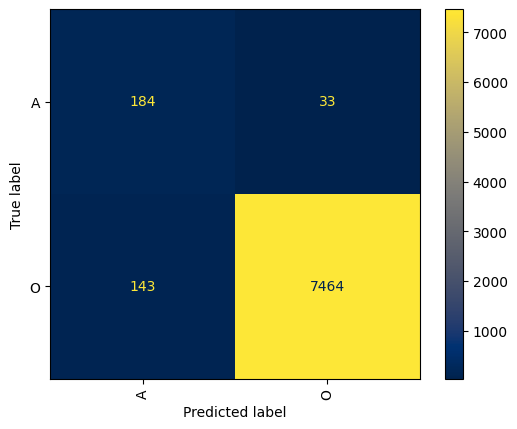

              precision    recall  f1-score   support

           A     0.5627    0.8479    0.6765       217
           O     0.9956    0.9812    0.9883      7607

    accuracy                         0.9775      7824
   macro avg     0.7791    0.9146    0.8324      7824
weighted avg     0.9836    0.9775    0.9797      7824



In [103]:
crf2_optimized_postregex_report_test = model_report(y_test_crf, y_test_pred, labels)

In [104]:
save_model_evaluation("CRF Contextual Features + REGEX PostProcessing", crf2_optimized_postregex_report_test, crf_test_models_report)

#### Model Comparison

##### Evaluation on Validation Data

In [105]:
print("Precision:")
crf_models_report[0].sort_values(by='A', ascending=False)

Precision:


,O,A,Weighted Avg,Macro Avg
CRF Contextual Features + REGEX,0.994627,0.891117,0.990153,0.942872
CRF Contextual Features + REGEX PostProcessing,0.994597,0.791349,0.985811,0.892973
CRF Contextual Features,0.992302,0.787634,0.983454,0.889968
CRF Basic Features + REGEX,0.992268,0.721675,0.980571,0.856971
CRF Basic Features + REGEX PostProcessing,0.994690,0.701124,0.982000,0.847907
CRF Basic Features,0.991227,0.686747,0.978065,0.838987


In [106]:
print("Recall:")
crf_models_report[1].sort_values(by='A', ascending=False)

Recall:


,O,A,Weighted Avg,Macro Avg
CRF Basic Features + REGEX PostProcessing,0.982977,0.883853,0.978692,0.933415
CRF Contextual Features + REGEX,0.995136,0.881020,0.990203,0.938078
CRF Contextual Features + REGEX PostProcessing,0.989505,0.881020,0.984815,0.935262
CRF Contextual Features,0.989889,0.830028,0.982978,0.909958
CRF Basic Features + REGEX,0.985537,0.830028,0.978815,0.907783
CRF Basic Features,0.983361,0.807365,0.975753,0.895363


In [107]:
print("F1 score:")
crf_models_report[2].sort_values(by='A', ascending=False)

F1 score:


,O,A,Weighted Avg,Macro Avg
CRF Contextual Features + REGEX,0.994882,0.886040,0.990177,0.940461
CRF Contextual Features + REGEX PostProcessing,0.992044,0.833780,0.985203,0.912912
CRF Contextual Features,0.991094,0.808276,0.983191,0.899685
CRF Basic Features + REGEX PostProcessing,0.988799,0.781955,0.979857,0.885377
CRF Basic Features + REGEX,0.988891,0.772069,0.979518,0.880480
CRF Basic Features,0.987278,0.742188,0.976684,0.864733


##### Evaluation of the Best Models on the Test Data

In [108]:
print("Precision:")
crf_test_models_report[0].sort_values(by='A', ascending=False)

Precision:


,O,A,Weighted Avg,Macro Avg
CRF Contextual Features + REGEX,0.995133,0.814480,0.990123,0.904807
CRF Contextual Features + REGEX PostProcessing,0.995598,0.562691,0.983591,0.779145
CRF Contextual Features,0.994274,0.552381,0.982018,0.773327
CRF Basic Features + REGEX PostProcessing,0.995188,0.527697,0.982222,0.761442


In [109]:
print("Recall:")
crf_test_models_report[1].sort_values(by='A', ascending=False)

Recall:


,O,A,Weighted Avg,Macro Avg
CRF Contextual Features + REGEX PostProcessing,0.981202,0.847926,0.977505,0.914564
CRF Basic Features + REGEX PostProcessing,0.978704,0.834101,0.974693,0.906403
CRF Contextual Features + REGEX,0.994610,0.829493,0.990031,0.912052
CRF Contextual Features,0.981464,0.801843,0.976483,0.891654


In [110]:
print("F1 score:")
crf_test_models_report[2].sort_values(by='A', ascending=False)

F1 score:


,O,A,Weighted Avg,Macro Avg
CRF Contextual Features + REGEX,0.994872,0.821918,0.990075,0.908395
CRF Contextual Features + REGEX PostProcessing,0.988347,0.676471,0.979697,0.832409
CRF Contextual Features,0.987827,0.654135,0.978572,0.820981
CRF Basic Features + REGEX PostProcessing,0.986877,0.646429,0.977435,0.816653


#### Error Analysis

##### CRF Model No.2 Contextual Feature Set

In [111]:
y_val_pred_crf2 = crf2_optimized.predict(X_val_crf2)
y_test_pred_crf2 = crf2_optimized.predict(X_test_crf2)

FN_val_crf2, FP_val_crf2 = get_false_predictions(list(X_val['word']), list(y_val), y_val_pred_crf2)
FN_test_crf2, FP_test_crf2 = get_false_predictions(list(X_test['word']), list(y_test), y_test_pred_crf2)

In [113]:
print("Validation Dataset")
print("False Negatives:")
for false_negative in FN_val_crf2:
    #print(false_negative)
    pass

print("\nFalse Positives:")
for false_positive in FP_val_crf2:
    #print(false_positive)
    pass

print("\nTest Dataset")
print("False Negatives:")
for false_negative in FN_test_crf2:
    #print(false_negative)
    pass

print("\nFalse Positives:")
for false_positive in FP_test_crf2:
    #print(false_positive)
    pass

Validation Dataset
False Negatives:

False Positives:

Test Dataset
False Negatives:

False Positives:


##### CRF Model No.4 Contextual + REGEX Feature Set

In [114]:
y_val_pred_crf4 = crf4_optimized.predict(X_val_crf4)
y_test_pred_crf4 = crf4_optimized.predict(X_test_crf4)

FN_val_crf4, FP_val_crf4 = get_false_predictions(list(X_val['word']), list(y_val), y_val_pred_crf4)
FN_test_crf4, FP_test_crf4 = get_false_predictions(list(X_test['word']), list(y_test), y_test_pred_crf4)

In [115]:
print("Validation Dataset")
print("False Negatives:")
for false_negative in FN_val_crf4:
    #print(false_negative)
    pass

print("\nFalse Positives:")
for false_positive in FP_val_crf4:
    #print(false_positive)
    pass

print("\nTest Dataset")
print("False Negatives:")
for false_negative in FN_test_crf4:
    #print(false_negative)
    pass

print("\nFalse Positives:")
for false_positive in FP_test_crf4:
    #print(false_positive)
    pass

Validation Dataset
False Negatives:

False Positives:

Test Dataset
False Negatives:

False Positives:


##### CRF Model No.6 Contextual Feature Set + REGEX PostProcessing

In [116]:
y_val_pred_crf6 = crf2_optimized.predict(X_val_crf2)
y_val_pred_crf6 = REGEX_postprocessing(X_val, y_val_pred_crf6)

y_test_pred_crf6 = crf2_optimized.predict(X_test_crf2)
y_test_pred_crf6 = REGEX_postprocessing(X_test, y_test_pred_crf6)

In [117]:
FN_val_crf6, FP_val_crf6 = get_false_predictions(list(X_val['word']), list(y_val), y_val_pred_crf6)
FN_test_crf6, FP_test_crf6 = get_false_predictions(list(X_test['word']), list(y_test), y_test_pred_crf6)

In [119]:
print("Validation Dataset")
print("False Negatives:")
for false_negative in FN_val_crf6:
    #print(false_negative)
    pass

print("\nFalse Positives:")
for false_positive in FP_val_crf6:
    #print(false_positive)
    pass

print("\nTest Dataset")
print("False Negatives:")
for false_negative in FN_test_crf6:
    #print(false_negative)
    pass

print("\nFalse Positives:")
for false_positive in FP_test_crf6:
    #print(false_positive)
    pass

Validation Dataset
False Negatives:

False Positives:

Test Dataset
False Negatives:

False Positives:


##### Saving the Best CRF Model

In [120]:
import pickle

with open('./models/crf_model.pkl', 'wb') as file:
    pickle.dump(crf4_optimized, file)

### RobeCzech Model

#### Imports

In [121]:
import torch 
import torch.nn as nn 
import torch.optim as optim
from torch import cuda
from transformers import BertTokenizerFast, AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification, pipeline
import datasets
from datasets import Dataset, DatasetDict
import tqdm    

#### Evaluation Report Initialization

In [122]:
metrics = datasets.load_metric("seqeval")
label_list = ["O", "B-A"]

def compute_metrics(log):
    predictions, labels = log
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [[label_list[pred] for (pred, tag) in zip(prediction,label) if tag != -100] 
                        for prediction, label in zip(predictions,labels)]
    true_labels = [[label_list[tag] for (pred, tag) in zip(prediction, label)if tag != -100] 
                   for prediction, label in zip(predictions, labels)]
    results = metrics.compute(predictions=true_predictions,references=true_labels)

    return {
        "Precision": results["overall_precision"],
        "Recall": results["overall_recall"],
        "F1 Score": results["overall_f1"]
    }

/tmp/ipykernel_7834/1271253569.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metrics = datasets.load_metric("seqeval")
/usr/local/lib/python3.8/dist-packages/datasets/load.py:753: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


#### Dataset Preparation

In [123]:
train_robe = robe_dataset(X_train, y_train)
val_robe = robe_dataset(X_val, y_val)
test_robe = robe_dataset(X_test, y_test)

In [124]:
train_dataset = Dataset.from_dict({key: [row[key] for row in train_robe] for key in train_robe[0].keys()})
val_dataset = Dataset.from_dict({key: [row[key] for row in val_robe] for key in val_robe[0].keys()})
test_dataset = Dataset.from_dict({key: [row[key] for row in test_robe] for key in test_robe[0].keys()})

dataset = DatasetDict({'train': train_dataset, 
                       'validation': val_dataset, 
                       'test': test_dataset}
                     )

In [125]:
id2label = {i : label_list[i] for i in range(len(label_list))}
label2id = {label_list[i] : i for i in range(len(label_list))}

#### Tokenization and Label Alignement

In [126]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased", is_split_into_words=True)

This function is from https://www.kaggle.com/code/vimalpillai/fine-tuning-language-models-for-ner

In [127]:
def tokenize_and_align_labels(examples, label_all_tokens=True):
    tokenized_inputs = tokenizer(examples["words"],truncation=True, is_split_into_words=True)
    labels = []
    
    for i, label in enumerate(examples["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx
            
        labels.append(label_ids)
        
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [128]:
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/5109 [00:00<?, ? examples/s]

Map:   0%|          | 0/1095 [00:00<?, ? examples/s]

Map:   0%|          | 0/1095 [00:00<?, ? examples/s]

In [129]:
data_collator = DataCollatorForTokenClassification(tokenizer)

#### RobeCzech Model

Hyperparameter Search

In [130]:
import optuna
import os

os.environ["WANDB_DISABLED"] = "true"

In [131]:
def objective(trial: optuna.Trial):
    model = AutoModelForTokenClassification.from_pretrained("ufal/robeczech-base", num_labels=2)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    training_args = TrainingArguments(
        output_dir="rcz_results",
        learning_rate=trial.suggest_loguniform("learning_rate", low=1e-5, high=5e-5),
        weight_decay=trial.suggest_loguniform("weight_decay", 1e-4, 0.1),
        num_train_epochs=trial.suggest_int("num_train_epochs", low=3, high=15),
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        disable_tqdm=False
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    result = trainer.train()
    return result.training_loss

In [132]:
study = optuna.create_study(direction='minimize') 
study.optimize(func=objective, n_trials=10)  

[I 2024-03-31 14:48:44,736] A new study created in memory with name: no-name-66f670b8-69ef-4be4-ac8e-aabf1d626d46
[W 2024-03-31 14:48:47,493] Trial 0 failed with parameters: {} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_7834/3248843402.py", line 2, in objective
    model = AutoModelForTokenClassification.from_pretrained("ufal/robeczech-base", num_labels=2)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/transformers/models/auto/auto_factory.py", line 436, in from_pretrained
    return model_class.from_pretrained(pretrained_model_name_or_path, *model_args, config=config, **kwargs)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/transformers/modeling_utils.py", line 1414, in from_pretrained
    model = cls(config, *model_args, **model_kwargs)
  File "/home/ubuntu/.local/lib/

KeyboardInterrupt: 

In [133]:
best_lr = 1.6851058387426426e-05
best_weight_decay = 0.08323798632860356
best_epoch = 14

In [134]:
model = AutoModelForTokenClassification.from_pretrained("ufal/robeczech-base", num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of the model checkpoint at ufal/robeczech-base were not used when initializing RobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at ufal/robeczech-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this 

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(51997, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (L

In [135]:
best_arguments = TrainingArguments(
    output_dir="./models/result",
    report_to="none",
    evaluation_strategy="epoch",
    learning_rate=best_lr,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=best_epoch,
    weight_decay=best_weight_decay
    )

In [136]:
best_trainer = Trainer(
    model,
    best_arguments,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    )

In [ ]:
best_trainer.train()

In [54]:
best_trainer.save_model('best_model')

Saving model checkpoint to best_model
Configuration saved in best_model/config.json
Model weights saved in best_model/pytorch_model.bin
tokenizer config file saved in best_model/tokenizer_config.json
Special tokens file saved in best_model/special_tokens_map.json


In [55]:
config = json.load(open("best_model/config.json"))
config["id2label"] = id2label
config["label2id"] = label2id
json.dump(config, open("best_model/config.json","w"))

#### Final Evaluation

In [138]:
def cf_pred_format(dataset: List[Dict[str, List[str]]], model: str) -> List[str]:
    ner = pipeline(
        'token-classification',
        model = model,
        aggregation_strategy = 'simple' , 
        device = 0 
    )

    y_pred = []
    for sentence in dataset:
        predictions = ner(sentence['words'])
        for prediction in predictions:
            if not prediction:
                y_pred.append('O')
            else:
                y_pred.append('A')
    return y_pred

In [250]:
y_test_pred = cf_pred_format(test_robe, 'best_model')

loading configuration file best_model/config.json
Model config RobertaConfig {
  "_name_or_path": "best_model",
  "architectures": [
    "RobertaForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-A"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-A": 1,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.14.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 51997
}

loading configuration file best_model/config.json
Model config RobertaConfig {
  "_name_or_path": "best_model"

In [42]:
def show_cf_for_robe(y: List[str], y_pred: List[str]) -> Dict[str, Dict[str, int]]:
    disp = ConfusionMatrixDisplay(confusion_matrix(y, y_pred), display_labels=['A', 'O'])
    disp.plot(cmap="cividis")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    print(classification_report(y, y_pred, labels=['A', 'O'], target_names=['A', 'O'], digits=4))
    return classification_report(y, y_pred, output_dict=True)

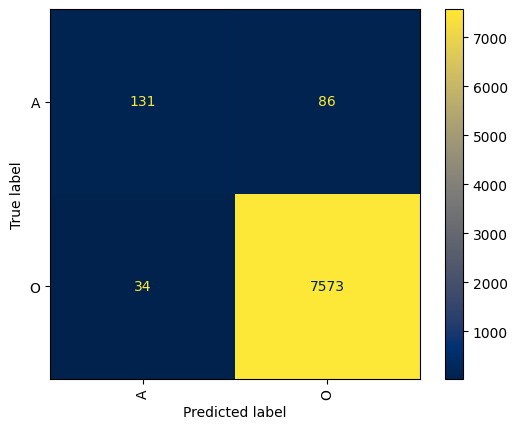

              precision    recall  f1-score   support

           A     0.7939    0.6037    0.6859       217
           O     0.9888    0.9955    0.9921      7607

    accuracy                         0.9847      7824
   macro avg     0.8914    0.7996    0.8390      7824
weighted avg     0.9834    0.9847    0.9836      7824



In [254]:
robecz_test_evaluation_report = show_cf_for_robe(list(chain.from_iterable(y_test)), y_test_pred)

In [262]:
def get_false_predictions_flattened(X: DataFrame, y: List[List[str]], y_pred: List[List[str]]) -> Tuple[List[Tuple[str, str, str]], List[Tuple[str, str, str]]]:
    FN = [(x, true_label, pred_label) for x, true_label, pred_label in zip(X, y, y_pred) if true_label != pred_label and pred_label == 'O']
    FP = [(x, true_label, pred_label) for x, true_label, pred_label in zip(X, y, y_pred) if true_label != pred_label and pred_label == 'A']
    return FN, FP

In [263]:
FN_test_robe, FP_test_robe = get_false_predictions_flattened(list(chain.from_iterable(list(X_test['word']))), list(chain.from_iterable(y_test)), y_test_pred)

In [ ]:
print("\nTest Dataset")
print("False Negatives:")
for false_negative in FN_test_robe:
    #print(false_negative)
    pass

print("\nFalse Positives:")
for false_positive in FP_test_robe:
    #print(false_positive)
    pass

print('False negatives test dataset: ', len(FN_test_robe))
print('False positives test dataset: ', len(FP_test_robe))